# <center> Regresión logística

La regresión logística es una variante de los modelos lineales en los que el valor que se predice se acota entre 0 y 1, representando la probabilidad de que ocurra un evento, por lo que se aplica a lo que se denomina *clasificación binaria*. La ecuación general de los modelos lineales se modifica así:

## $\log \frac{p}{1 - p} = b_0 + b_1 x_1 + b_2 x_2 + \cdots + b_n x_n$

![](img/LogisticRegression.png)

donde ahora $p$ representa la probabilidad de que ocurra el evento que se estudia (por ejemplo, que un paciente al que se le hace un análisis de sangre tenga un tumor maligno o no). Cuando se hace una predicción usando un modelo de regresión logística sobre nuevos datos, se obtiene un número entre 0 y 1 que se suele denominar *score*. Si supera cierto valor umbral (denominado también *punto de corte*) entonces se considera que se va a producir el evento. Por tanto, no solo hay que entrenar el modelo, además hay que elegir un valor umbral que sea óptimo. Para ello se utilizan las curvas ROC (Receiver Operating Characteristic).

Comenzamos como siempre, cargando las librerías que vamos a necesitar y configurando el entorno:

In [40]:
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)

from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score, balanced_accuracy_score, log_loss, roc_auc_score
from sklearn.metrics         import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

Subimos el archivo de datos a Colab y lo cargamos en memoria, especificando que PassengerId se tomará como índice:

In [2]:
##### DOWNLOAD DATASET. ONLY IN COLAB !!
#!wget -P ./data/ "https://raw.githubusercontent.com/SaturdaysAI-Murcia/machine-learning/master/2.%20Tabular%20data%20(clas)/data/titanic_train.csv"

In [3]:
train_df = pd.read_csv("data/titanic_train.csv", index_col='PassengerId') 

Los datos se corresponden al dataset de victimas del Titanic, los detalles se pueden consuntar [aquí](https://www.kaggle.com/c/titanic/data). Echamos un vistazo a los datos y hacemos una breve descripción estadística, primero de las variables cuantitativas y luego de las cualitativas:

In [4]:
train_df.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_df.describe(include=['object', 'bool'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Saad, Mr. Khalil",male,1601,B96 B98,S
freq,1,577,7,4,644


# Preprocessing
Vemos que hay un total de 891 pasajeros, pero solo tenemos la edad de 714. Y solo conocemos el camarote (Cabin) de 204 y el puerto de embarque (Embarked) de 889. También vemos que hay algunas variables que no parecen contener ninguna información: el nombre del pasajero (Name), el número de ticket (Ticket) y el número de camarote (Cabin). Por tanto haremos varias cosas para limpiar el dataset:

- Eliminar las variables (columnas) Name, Ticket, y Cabin
- Eliminar los casos (filas) en los que no estén especificados la edad y/o el puerto de embarque

In [8]:
numeric_features     = ['Age', 'Fare', "SibSp", "Parch"]
categorical_features = ['Embarked', 'Pclass']
binary_features      = ['Sex']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
    #('scaler',  StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label',   OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer,     numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('bin', binary_transformer,      binary_features)
])

In [9]:
transformed_data = preprocessor.fit_transform(train_df)

def get_transformer_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

var_names = get_transformer_feature_names(preprocessor)
df_prepro = pd.DataFrame(transformed_data, columns=var_names)
df_prepro.head()

,Age,Fare,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing,Pclass_1,Pclass_2,Pclass_3,Sex_male
0,22.0,7.2500,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,38.0,71.2833,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,26.0,7.9250,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,35.0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,35.0,8.0500,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


Ahora hemos eliminado la columnna Embarked, sustituyéndola por tres columnas: C (Cherbourg), Q (Queenstown) y S (Southampton). Para el sexo, tenemos ahora que male=1 y female=0. Con el one-hot-encoding nunca habrá un caso en el que C sea 1 y Q o S sean también 1, ni ninguna otra combinación. Solo una de las tres puede ser 1. Esta transformación nos permite incluir variables cualitativas en los modelos lineales.

# Train Model

Definimos ahora las variables de entrenamiento (X) y la variable a predecir (Y)

In [10]:
x = df_prepro
y = train_df['Survived']

Dividimos el dataset en subconjuntos de entrenamiento (80%) y de validación (20%), estratificando según la supervivencia del pasajero:

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

Ya podemos crear el modelo de regresión logística:

In [12]:
model = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=0)
model.fit(x_train, y_train);

# Evaluate model

Ahora para cada pasajero tenemos tanto la predicción como una probabilidad de que sobreviva. Podemos representar la matriz de confusión y cómo se relacionan estas probabilidades con el verdadero valor de Survived, tanto para el entrenamiento como para la validación:

Accuracy:          78.2122905027933
Balanced accuracy: 77.41106719367589
Area Under Curve:  0.7741106719367589
Log loss:          7.5253020723326856


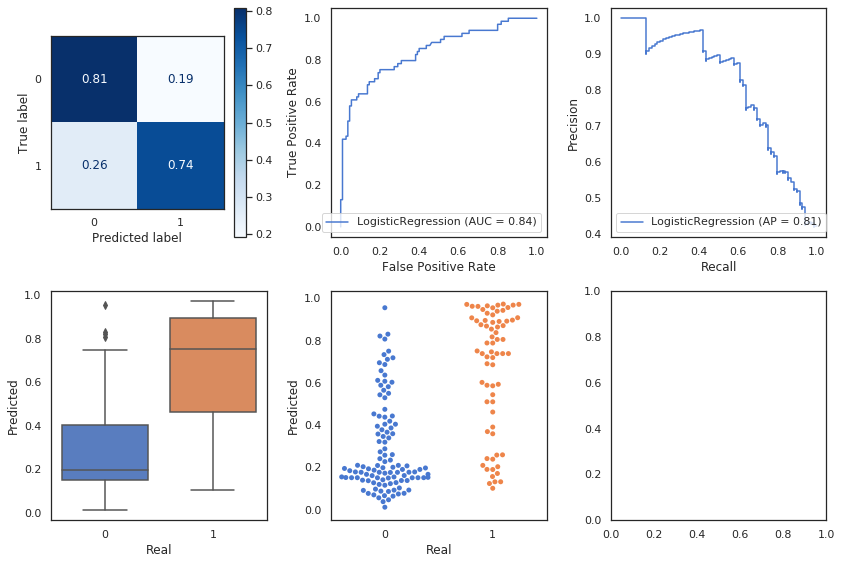

In [46]:
y_pred       = model.predict(x_val)
y_pred_proba = model.predict_proba(x_val)[:, 1]
results      = pd.DataFrame({"Predicted": y_pred_proba, "Real": y_val})

print("Accuracy:         ", accuracy_score(y_val, y_pred)*100)
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_pred)*100)
print("Area Under Curve: ", roc_auc_score(y_val, y_pred))
print("Log loss:         ", log_loss(y_val, y_pred))


f, axes = plt.subplots(2, 3, figsize=(12, 8))
plot_confusion_matrix(      model, x_val, y_val, ax=axes[0, 0], cmap=plt.cm.Blues, normalize="true")
plot_roc_curve(             model, x_val, y_val, ax=axes[0, 1])
plot_precision_recall_curve(model, x_val, y_val, ax=axes[0, 2])
sns.boxplot(  x="Real", y="Predicted", data=results, ax=axes[1, 0])
sns.swarmplot(x="Real", y="Predicted", data=results, ax=axes[1, 1])
plt.tight_layout()

Vemos que la precisión ponderada del modelo (balanced accuracy) es razonablemente buena (79.1%), aunque no demasiado: como la proporción de fallecidos es del 59.6% (424 / 712) si decimos sin analizar ningún dato que el pasajero se ahoga tenemos una probabilidad basal del 59.6% de acertar. Vemos en el gráfico de cajas que la distribución de *scores* es muy parecida entre los que se ahogan y los que no. Cuando los modelos son muy buenos las cajas están muy separadas. No es el caso aquí.

# See coeficients

In [48]:
pd.DataFrame({'Variable': var_names,'Coeficiente': model.coef_[0]})

,Variable,Coeficiente
0,Age,-0.039761
1,Fare,0.003721
2,SibSp,-0.351402
3,Parch,-0.049970
4,Embarked_C,0.059739
5,Embarked_Q,-0.028872
6,Embarked_S,-0.216571
7,Embarked_missing,0.186158
8,Pclass_1,0.970161
9,Pclass_2,0.074209


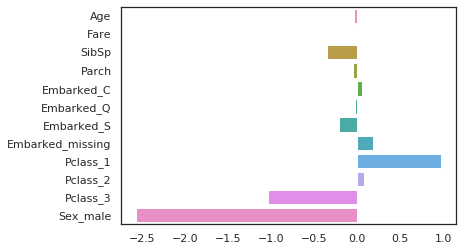

In [49]:
sns.barplot(x=model.coef_[0], y=var_names);

Apliquemos ahora el modelo al conjunto de validación:

Los resultados son parecidos a los del conjunto de entrenamiento. Tenemos una balanced accuracy algo menor, del 77.5%, y la distribución de scores entre grupos es también muy parecida y no demasiado buena. Ojo, aún no hemos estudiado el punto de corte óptimo para separar los dos grupos, lo que haremos usando la curva ROC. Para una explicación detallada sobre las curvas ROC y los conceptos de sensibilidad, especificidad, area bajo la curva y puntos de corte se puede consultar este [link](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

El principal parámetro de calidad de una curva ROC es el área bajo la curva (AUC, Area Under Curve), que en este caso es 0.861. Su valor oscila entre 0.5 (modelo no informativo) y 1 (modelo perfecto), por lo que nuestro modelo es razonablemente bueno, aunque nada del otro mundo. En la gráfica se nos indica que el punto de corte óptimo es 0.083, una cifra bastante baja: todos los pasajeros que tengan una probabilidad mayor se clasifican como supervivientes, el resto como ahogados.

Existen muchas maneras de definir la calidad de un modelo, habiendo multitud de índices cada uno con sus ventajas e inconvenientes. Para saber más sobre ellos se puede consultar por ejemplo este [link](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/).

Ya hemos visto que el AUC es razonablemente alto, y la sensibilidad también lo es (0.966), pero resulta curioso que la especificidad sea tan baja (0.235). Probablemente indica que el modelo tiende a predecir que el pasajero va a ahogarse, y luego va afinando la predicción.

Aunque el modelo no es muy bueno, tenemos ahora la ventaja de que podemos determinar cómo afecta cada variable a al predicción. Para ello se usa el concepto de "odds ratio" (OR), que es cuánto crece o decrece la probabilidad de salvarse cuando el valor de la variable cambia en 1 unidad:

Vamos a interpretar estos resultados. El OR para Pclass es 0.33, lo que quiere decir que cuando la clase aumenta en 1 unidad, la probabilidad de salvarse se multiplica por 0.33. O sea, si los de primera clase (pclass=1) tienen cierta probabilidad de salvarse P1, los de segunda clase tienen una probabilidad P2 = 0.33·P1 de salvarse (un tercio) que los de primera clase, y los de tercera clase P3 = 0.33·P2 = 0.33·0.33·P1, aproximadamente un 10% de la probabilidad de los de primera clase. Vemos que para sexo, la probabilidad de salvarse para los hombres es menos de una décima parte que para las mujeres (0.08). Vemos también que la edad prácticamente no influye, ya que el OR está muy próximo a 1 (misma probabilidad sea cual sea la edad). Resulta también curioso que los que embarcaron en Cherbourg tienen más probabilidad de salvarse que los de Southampton y los de Queenstown (1.55 / 1.13 / 0.56)

La conclusión que sacamos de la regresión logística es que aunque el modelo no es muy potente (accuracy de alrededor de 80%), sí que podemos sacar muchas conclusiones de él y manipularlo a nuestro gusto muy fácilmente. Estas conclusiones las podemos aplicar luego a otros modelos más potentes para afinar más las predicciones. Por ejemplo, si sabemos que la edad no tiene efecto apreciable podemos suprimirla, lo que probablemente reduzca el riesgo de sobreajuste.